# 1. 데이터 준비

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# 2. 전처리

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
# price는 라벨이기 때문에 분리 해주고 trian에서 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# id도 분석을 하는데 있어서 필요없기 때문에 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# test 데이터도 동일한 전처리를 진행
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

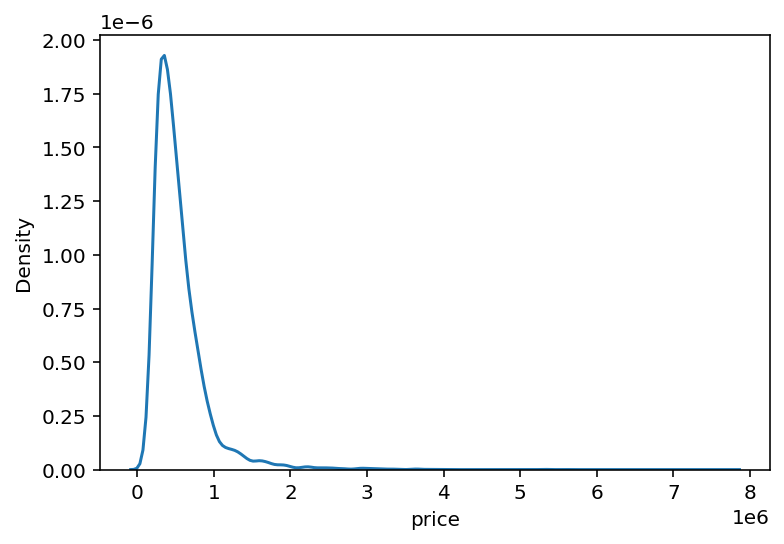

In [10]:
# y 라벨 부분 값의 분포를 보니 한쪽으로 치우쳐있다.
sns.kdeplot(y)
plt.show()

In [11]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

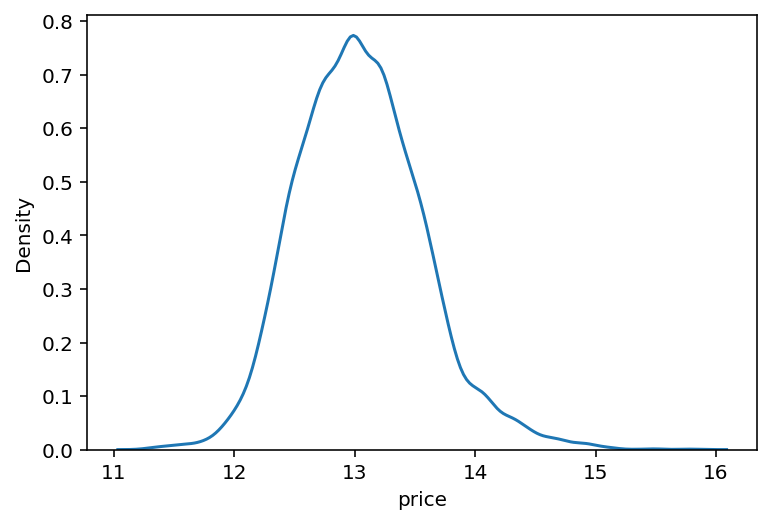

In [12]:
# 어느정도 치우침이 줄어든 분포 확인
sns.kdeplot(y)
plt.show()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 3. 모델 학습

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
# 평가 척도 RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [16]:
# 분석에 사용할 모델을 호출
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [17]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값이다.
random_state=2020  

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [19]:
#  for문 안에서 각 모델 별로 학습 및 예측

df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [20]:
# 지금까지의 과정을 하나의 함수로 정리
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

# 4. GridSearch

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
# grid에 탐색을 할 xgboost관련 하이퍼 파라미터
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [23]:
# LGBMRegressor를 사용해서 적용
model = LGBMRegressor(random_state=random_state)

In [24]:
grid_model = GridSearchCV(model, param_grid=param_grid, 
                        scoring='neg_mean_squared_error', 
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [25]:
grid_model.cv_results_

{'mean_fit_time': array([0.15828128, 0.2108664 , 0.39912076, 0.48889823]),
 'std_fit_time': array([0.05569241, 0.07004694, 0.14605116, 0.08104233]),
 'mean_score_time': array([0.00725551, 0.02528229, 0.01947947, 0.03927174]),
 'std_score_time': array([0.00024343, 0.01814899, 0.00399504, 0.01462489]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [26]:
# params 중 테스트 점수 인 mean_test_score값만을 호출
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [27]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [28]:
# MSE에 음수 값을 넣어 scoring을 하기 때문에 score값이 음수가 나옴
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [29]:
# 호출한 score값이 음수이기 때문에 양수로 바꿔줌
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [30]:
# Root Mean Squared Log Error
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [31]:
# 오름차순으로 정렬
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [32]:
# GridSearch 를 통해 알아내는 과정을 하나의 함수로 정리
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [33]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [1, 10, 20, 30]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,max_depth,n_estimators,score,RMSLE
23,30,300,-0.026091,0.161527
17,20,300,-0.026091,0.161527
16,20,250,-0.026127,0.161638
22,30,250,-0.026127,0.161638
11,10,300,-0.026127,0.161640
10,10,250,-0.026136,0.161667
9,10,200,-0.026188,0.161828
21,30,200,-0.026245,0.162003
15,20,200,-0.026245,0.162003
8,10,150,-0.026458,0.162660


In [34]:
# gird를 통해 얻은 값을 통해 파라미터를 LGBMRegressor에 적용
model = LGBMRegressor(max_depth=30, n_estimators=300, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12160458, 13.10226918, 14.15043868, ..., 13.05037436,
       12.67158278, 13.01735592])

In [35]:
# y값에 대해서 진행한 스케일을 되돌림
prediction = np.expm1(prediction)
prediction

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

# 5. 제출

In [36]:
# 나온 결과를 바탕으로 저장
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [37]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.996197e+05
1,15036,4.900522e+05
2,15037,1.397839e+06
3,15038,3.072446e+05
4,15039,3.279127e+05


In [38]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161527')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161527.csv
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=150; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=250; total time=   1.3s
[CV] END .....................max_depth=10, n_estimators=300; total time=   1.4s
[CV] END ......................max_depth=20, n_estimators=50; total time=   0.4s
[CV] END ......................max

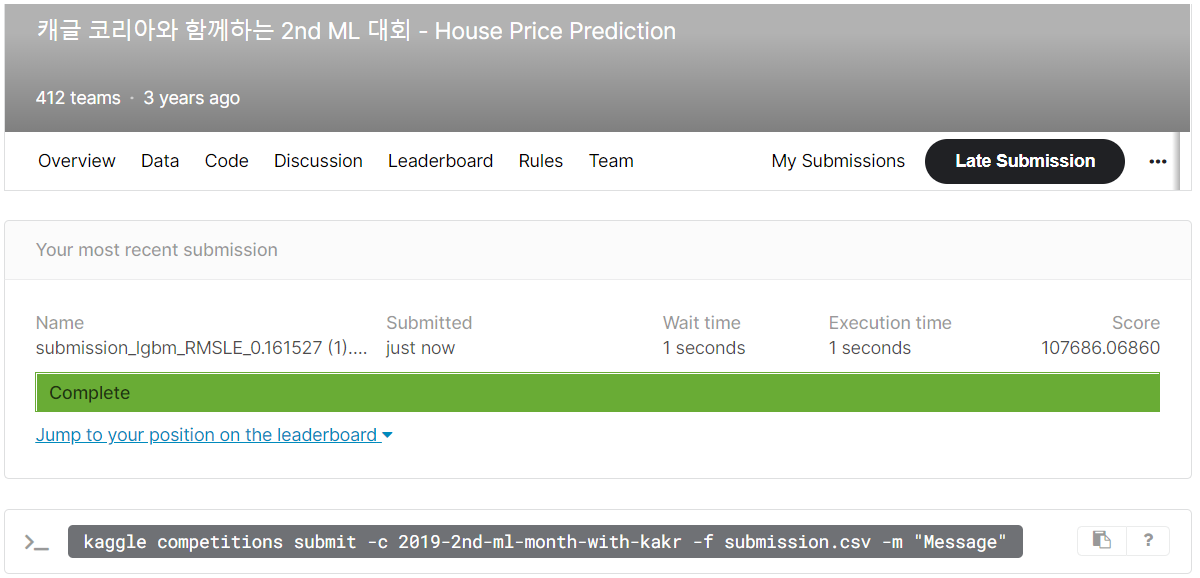

# 회고

- Private score 기준 110000 이하의 점수를 얻기까지 시간이 많이 걸렸다. 
  gboost, xgboost, lightgbm, rdforest 모델들을 돌린 결과로 lightgbm(LGBMRegressor)이 가장 성능이 좋았다. 
  그리고 GridSearch할 때 n_estimators, max_depth를 더 늘려 RMSLE의 값이 0.161527로 가장 낮은 n_estimators, max_depth을 찾고 다시 모델에 적용해서 107686점을 얻었다.
  
  
  
- 이 프로젝트를 할 때 머신러닝을 이용하여 분석을 했는데 왜 딥러닝을 이용하지 않았는지 궁금했다.
  머신러닝, 딥러닝 관련 노드와 책을 읽으면서 그 해답을 찾을 수 있었다.
  kaggle에서 주어진 데이터는 이미 특징을 가지고 있어 머신러닝으로 회귀를 예측할 때 전처리해준 특징을 기반으로 결과를 반환하기 때문에 머신러닝을 사용했을 것이다.
  반면에 딥러닝은 데이터의 특징을 가지고 분석하기 보다는 스스로 특징을 발견하고 그것을 바탕으로 값을 추출하기 때문에 이 데이터만으로 특징을 발견하고 예측하기에는 데이터량이 부족해서 딥러닝으로 분석했다면 머신러닝의 결과값만큼 좋은 결과값을 도출하지 못했을 것이다.